In [ ]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='viridis', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
def initialize_optimizer_state(mlp, optimizer):
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [ ]:
input_size = 3
hidden_sizes = [2, 3] 
output_size = 1
initial_activation_list = [jax.nn.relu, jax.nn.tanh, sin]

hetero_config = MLPConfig(input_size=input_size,
                        output_size=output_size,
                        hidden_sizes=hidden_sizes,
                        initial_activation_list=initial_activation_list,
                        seed=42)

In [ ]:
mlp = CustomMLP(hetero_config)

2024-05-27 13:16:46.983882: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


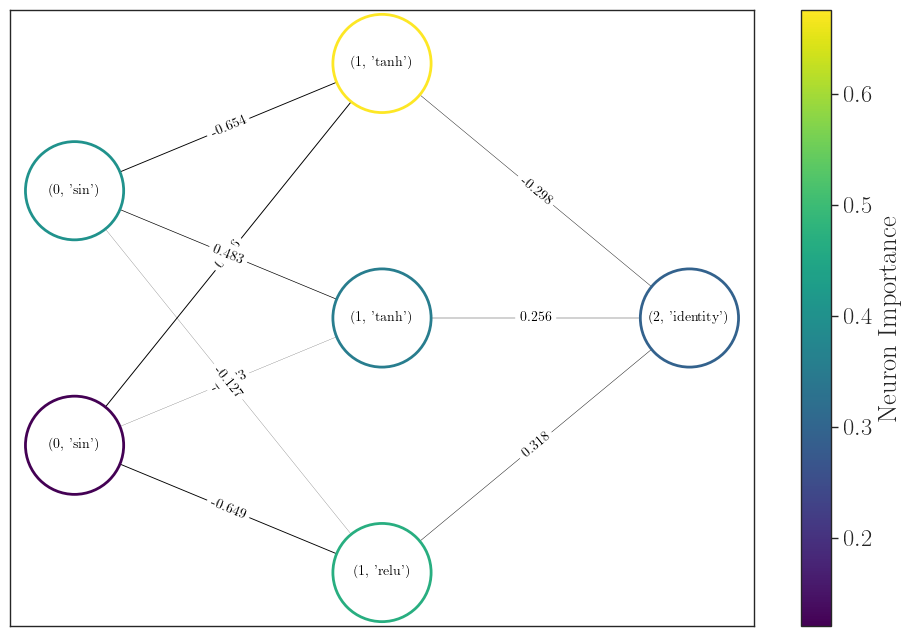

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.show()

In [ ]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = mlp(x)
    return jnp.mean((pred - y) ** 2)

In [ ]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [ ]:
x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([1.0])

In [ ]:
mlp = CustomMLP(hetero_config)
opt = optax.sgd(learning_rate=1e-2)
opt_state = initialize_optimizer_state(mlp, opt)

In [ ]:
initial_adjacency_matrix = mlp.adjacency_matrix()

<matplotlib.image.AxesImage>

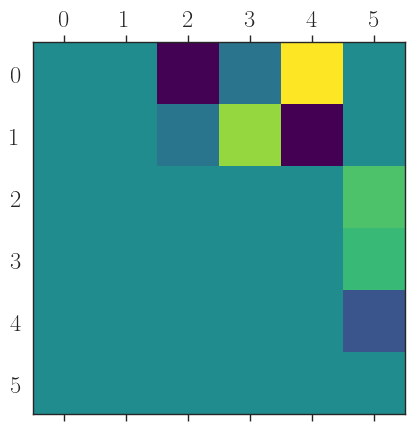

In [ ]:
plt.matshow(initial_adjacency_matrix, cmap=plt.cm.viridis)

In [ ]:
activation_list = [jax.nn.relu, sin, jax.nn.tanh]
num_epochs = 1000
add_node_every = 50
remove_node_every = 50
key = jax.random.PRNGKey(42)
Loss_history = []
Node_history = []
graph_history = []
Update_history = []
threshold = 1e-8

In [ ]:
for epoch in range(num_epochs):
    loss, mlp, opt_state = train_step(mlp, x, y, opt_state, opt.update)
    print(f"Epoch {epoch}, Prediction: {mlp(x)}, Loss: {loss}")

    key, add_key, sub_key = jax.random.split(key,3)
    n_neurons = sum(mlp.get_shape())
    Loss_history.append(loss)
    Node_history.append(n_neurons)


    # Dynamically add or remove neurons
    if (epoch + 1) % add_node_every == 0:
        if len(Update_history) == 0 or Update_history[-1][2] > loss or Update_history[-1][3] == "removed":
            # if no previous addition or last addition was rejected, add a neuron
            # if last addition was accepted, add a neuron
            add_key, act_key = jax.random.split(add_key)
            activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
            layer_idx = mlp.most_important_layer()
            mlp.add_neuron(layer_index=layer_idx, activation=activation, key=act_key)
            opt_state = initialize_optimizer_state(mlp, opt)

            Update_history.append((epoch, n_neurons, loss, activation.__name__, layer_idx))
            print(f"Added neuron to hidden layer {layer_idx+1} with activation {activation.__name__}")
            print(mlp.get_shape())
        
        elif Update_history[-1][2] < loss:
            # if last addition doesn't improve loss, remove the worst neuron

            layer_idx, neuron_idx = mlp.least_important_neuron()
            print(f"Removing neuron from hidden layer {layer_idx+1} at index {neuron_idx}")
            mlp.remove_neuron(layer_index=layer_idx, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            Update_history.append((epoch, n_neurons, loss, "removed", layer_idx))
            print(f"Rejecting last addition,\n Removed neuron from hidden layer {layer_idx+1} at index {neuron_idx}")
            print(mlp.get_shape())
        
    if loss < threshold:
        # if loss is below threshold, stop training
        print(f"Threshold reached, stopping training at epoch {epoch}")
        break
    


print("Final Prediction:", mlp(x))

Epoch 0, Prediction: 0.4947441518306732, Loss: 0.2983377277851105
Epoch 1, Prediction: 0.5330743193626404, Loss: 0.2552834451198578
Epoch 2, Prediction: 0.5688892006874084, Loss: 0.21801958978176117
Epoch 3, Prediction: 0.6022968888282776, Loss: 0.18585652112960815
Epoch 4, Prediction: 0.6334093809127808, Loss: 0.158167764544487
Epoch 5, Prediction: 0.6623414158821106, Loss: 0.13438868522644043
Epoch 6, Prediction: 0.6892081499099731, Loss: 0.11401332169771194
Epoch 7, Prediction: 0.7141245007514954, Loss: 0.09659157693386078
Epoch 8, Prediction: 0.73720383644104, Loss: 0.08172480016946793
Epoch 9, Prediction: 0.7585572600364685, Loss: 0.06906182318925858
Epoch 10, Prediction: 0.778292715549469, Loss: 0.05829459801316261
Epoch 11, Prediction: 0.796514630317688, Loss: 0.049154121428728104
Epoch 12, Prediction: 0.8133237361907959, Loss: 0.0414062961935997
Epoch 13, Prediction: 0.828816294670105, Loss: 0.03484802693128586
Epoch 14, Prediction: 0.843083918094635, Loss: 0.029303861781954765

In [ ]:
Update_history

[(49, 6, Array(5.3936197e-05, dtype=float32), 'sin', Array(1, dtype=int32))]

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

<matplotlib.image.AxesImage>

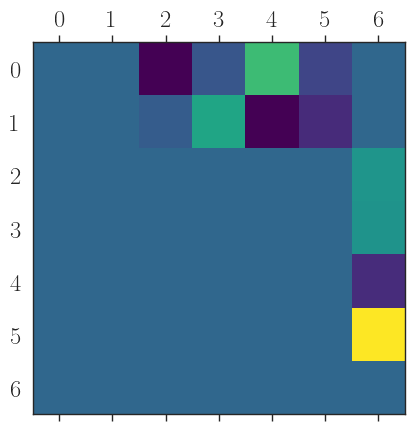

In [ ]:
plt.matshow(final_adjacency_matrix, cmap=plt.cm.viridis)

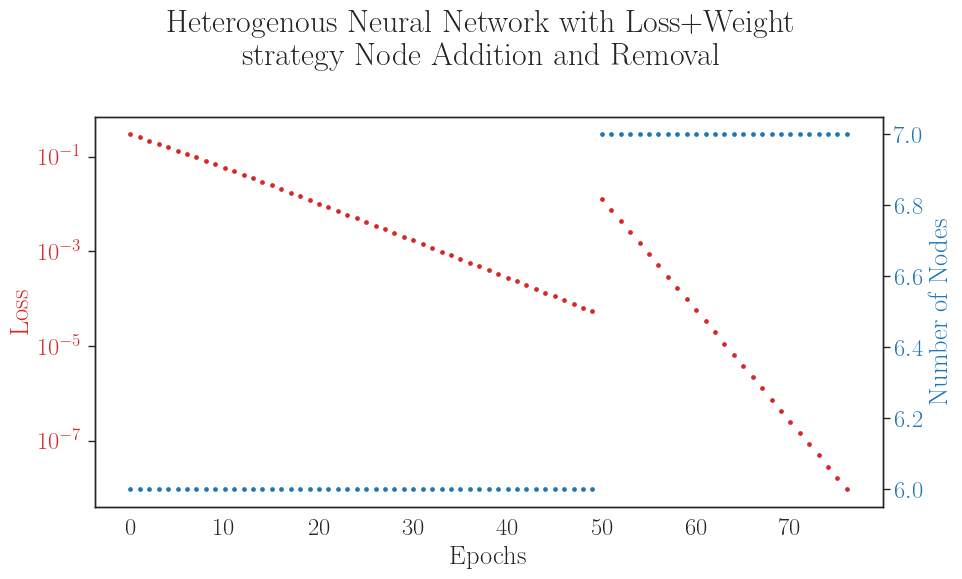

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,len(Loss_history)), Loss_history, ".", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,len(Node_history)), Node_history, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Heterogenous Neural Network with Loss+Weight\n strategy Node Addition and Removal")
fig.tight_layout()

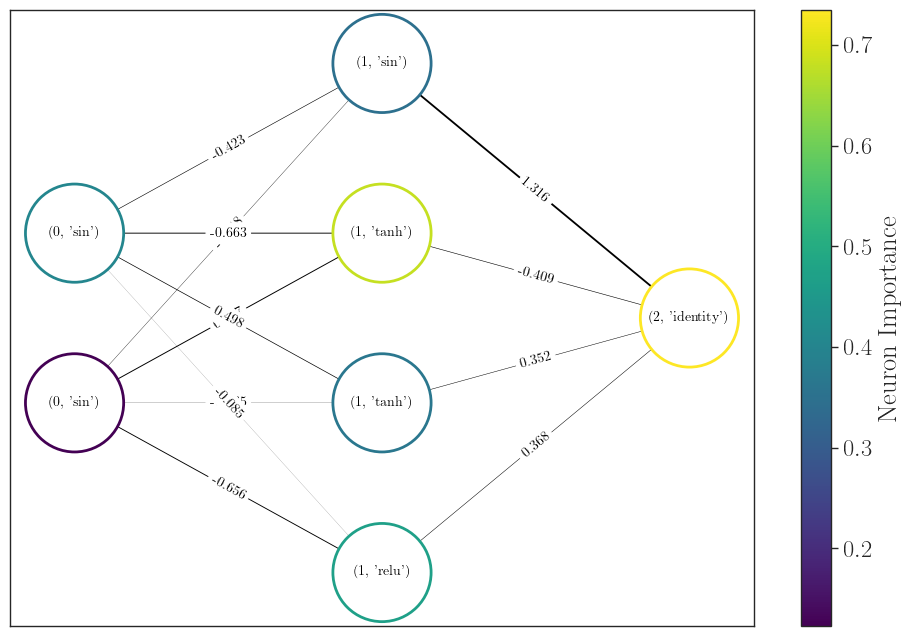

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.show()